In [2]:
import imp
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import h5py

import util
from plot_core import PlotAx, STYLE_PATH
from util import *
from data_loader import LoadRealCris
from plot_model_training import *

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

/home/cali/bin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [3]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers

Using TensorFlow backend.


In [4]:
style_file = os.path.join(STYLE_PATH, 'plot_regression.mplstyle')
plt.style.use(style_file)

In [6]:
in_dir = '/home/cali/data/GapFilling/CRIS/'
pic_dir = 'Picture'
result_dir = 'Result'
data_dir = 'Data'
model_dir = 'Model'
for _dir in [pic_dir, result_dir, data_dir, model_dir]:
    if not os.path.isdir(_dir):
        os.makedirs(_dir)
    print(_dir)

Picture
Result
Data
Model


# 合成全部的Real CRIS数据

In [26]:
class LoadRealCris:
    def __init__(self, in_file):
        self.in_file = in_file

    def get_spectrum_radiance(self):
        """
        return 光谱波数和响应值，1维，2维
        """

        shape = (16200, 1)
        # 增加切趾计算
        w0 = 0.23
        w1 = 0.54
        w2 = 0.23
        data_file = self.in_file
        with h5py.File(data_file, 'r') as h5r:
            sds_name = '/All_Data/CrIS-FS-SDR_All/ES_RealLW'
            real_lw = h5r.get(sds_name)[:]

            sds_name = '/All_Data/CrIS-FS-SDR_All/ES_RealMW'
            real_mw = h5r.get(sds_name)[:]

            sds_name = '/All_Data/CrIS-FS-SDR_All/ES_RealSW'
            real_sw = h5r.get(sds_name)[:]

        # 切趾计算 w0*n-1 + w1*n + w2*n+1 当作n位置的修正值
        # 开头和结尾不参与计算
        real_lw[:, :, :, 1:-1] = w0 * real_lw[:, :, :, :-2] + \
            w1 * real_lw[:, :, :, 1:-1] + w2 * real_lw[:, :, :, 2:]
        real_mw[:, :, :, 1:-1] = w0 * real_mw[:, :, :, :-2] + \
            w1 * real_mw[:, :, :, 1:-1] + w2 * real_mw[:, :, :, 2:]
        real_sw[:, :, :, 1:-1] = w0 * real_sw[:, :, :, :-2] + \
            w1 * real_sw[:, :, :, 1:-1] + w2 * real_sw[:, :, :, 2:]
        real_lw = real_lw[:, :, :, 2:-2]
        real_mw = real_mw[:, :, :, 2:-2]
        real_sw = real_sw[:, :, :, 2:-2]

        response = np.concatenate((real_lw, real_mw, real_sw), axis=3)
        last_s = response.shape[-1]
        # 16200*最后一个光谱维度
        response = response.reshape(-1, last_s)

        return response

In [30]:
def load_all_real_cris(in_files):
    response_all = None
    for in_file in in_files:
        response = LoadRealCris(in_file).get_spectrum_radiance()
        if response_all is None:
            response_all = response
        else:
            response_all = np.concatenate((response_all, response), axis=0)
    return response_all

# 加载全部波段数据

In [31]:
real_cris_files = [os.path.join(in_dir, i) for i in os.listdir(in_dir)]

In [32]:
X_all = load_all_real_cris(real_cris_files)

(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)
(60, 30, 9, 717)
(60, 30, 9, 713)


In [7]:
print(type(X_all))
print(type(Y_all))

print(X_all.shape)
print(Y_all.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(275881, 2211)
(275881, 1158)


In [8]:
# 判断是否有小于0和等于nan的无效值
print(np.where(X_all<=0)[0].shape)
print(np.where(Y_all<=0)[0].shape)

print(np.where(np.isnan(X_all))[0].shape)
print(np.where(np.isnan(Y_all))[0].shape)

print(np.where(X_all<=0)[0].shape)
print(np.where(Y_all<=0)[0].shape)

print(np.where(np.isnan(X_all))[0].shape)
print(np.where(np.isnan(Y_all))[0].shape)

(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


# 加载预测波段的数据

In [33]:
# 所有测量通道和预测通道每一波段的范围和分辨率 (start, end, frequency)
ranges_X_all = [(650., 1095., 0.625), (1210., 1750., 0.625), (2155., 2550., 0.625), ]
ranges_Y_all = [(1095.625, 1209.375, 0.625), (1750.625, 2154.375, 0.625), (2550.625, 2755., 0.625), ]

# 当前测量通道和预测通道每一波段的范围和分辨率 (start, end, frequency)
ranges_X = ranges_X_all
# ranges_X = [(650., 1095, 0.625), ]
# ranges_X = [(1210., 1750, 0.625), ]
# ranges_X = [(2155., 2550., 0.625), ]
ranges_Y = ranges_Y_all
# ranges_Y = [(1095.625, 1209.375, 0.625), ]
# ranges_Y = [(1750.625, 2154.375, 0.625), ]
# ranges_Y = [(2550.625, 2755., 0.625), ]

In [34]:
if ranges_X != ranges_X_all:
    test_X = get_data_by_wavenumber_range(X_all, wavenumber_X_all, ranges_X)
else:
    test_X = X_all

In [35]:
wavenumber_X_all = get_wavenumber_by_range(ranges_X_all)
wavenumber_Y_all = get_wavenumber_by_range(ranges_Y_all)

wavenumber_X = get_wavenumber_by_range(ranges_X)
wavenumber_Y = get_wavenumber_by_range(ranges_Y)

index_X = get_range_index_by_range(ranges_X)
index_Y = get_range_index_by_range(ranges_Y)

print(index_X)
print(index_Y)

[[   0  713]
 [ 713 1578]
 [1578 2211]]
[[   0  183]
 [ 183  830]
 [ 830 1158]]


In [12]:
print(type(test_X))
print(type(test_Y))
print(type(wavenumber_X))
print(type(wavenumber_Y))
print(type(index_X))
print(type(index_Y))

print(test_X.shape)
print(test_Y.shape)
print(wavenumber_X.shape)
print(wavenumber_Y.shape)
print(index_X.shape)
print(index_Y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(275881, 2211)
(275881, 1158)
(2211,)
(1158,)
(3, 2)
(3, 2)


In [13]:
print(np.where(test_X<=0)[0].shape)
print(np.where(test_Y<=0)[0].shape)

print(np.where(np.isnan(test_X))[0].shape)
print(np.where(np.isnan(test_Y))[0].shape)

(0,)
(0,)
(0,)
(0,)


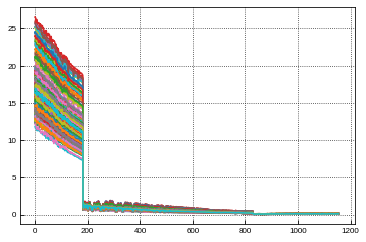

In [14]:
for i in range(500, 1000):
    plt.plot(test_Y[i])

In [41]:
def get_predict_data_by_linear_model(test_X, linear_model_attribute_business):
    """
    通过线性模型的模型系数获取预测值
    """
    lin_reg = LinearRegression()
    coef, intercept = get_linear_model_attributes(linear_model_attribute_business)
    lin_reg.coef_ = coef.T
    lin_reg.intercept_ = intercept.T
    predict_Y_linear = lin_reg.predict(test_X)

    return predict_Y_linear

In [37]:
def get_valid_data(test_X, test_Y, predict_Y_linear):
    """
    通过预测的数据获取剔除无效值的真值数据和预测数据
    """
    index = predict_Y_linear <= 0
    if not index.any():  # 如果预测数据的所有数据都是有效值，直接返回原来的结果
        print('all data is valid')
        return test_X, test_Y, predict_Y_linear
    else:
        # 去除预测结果中含无效值（<=0）的光谱
        test_X_linear_tmp = test_X.copy()
        test_Y_linear_tmp = test_Y.copy()
        predict_Y_linear_tmp = predict_Y_linear.copy()

        test_X_linear_tmp = pd.DataFrame(test_X_linear_tmp)
        test_Y_linear_tmp = pd.DataFrame(test_Y_linear_tmp)
        predict_Y_linear_tmp = pd.DataFrame(predict_Y_linear_tmp)
        print(test_X_linear_tmp.shape)
        print(test_Y_linear_tmp.shape)
        print(predict_Y_linear_tmp.shape)

        index = predict_Y_linear_tmp <= 0

        test_X_linear_tmp[index] = np.nan
        test_Y_linear_tmp[index] = np.nan
        predict_Y_linear_tmp[index] = np.nan

        test_X_linear_tmp = test_X_linear_tmp.dropna(axis=0)
        predict_Y_linear_tmp = predict_Y_linear_tmp.dropna(axis=0)
        test_Y_linear_tmp = test_Y_linear_tmp.dropna(axis=0)
        print(test_X_linear_tmp.shape)
        print(test_Y_linear_tmp.shape)
        print(predict_Y_linear_tmp.shape)

        test_X_linear_tmp = np.array(test_X_linear_tmp)
        test_Y_linear_tmp = np.array(test_Y_linear_tmp)
        predict_Y_linear_tmp = np.array(predict_Y_linear_tmp)

        return test_X_linear_tmp, test_Y_linear_tmp, predict_Y_linear_tmp

In [38]:
def get_predict_data(model_name):
    # 得到预测结果和预测的TBB
    linear_model_attribute_file_business = os.path.join(model_dir, 'linear_model_attribute_{}.h5'.format(model_name))
    print(linear_model_attribute_file_business)
    predict_Y_business = get_predict_data_by_linear_model(test_X, linear_model_attribute_file_business)
    test_X_tmp_business, test_Y_tmp_business, predict_Y_tmp_business = get_valid_data(test_X, test_Y, predict_Y_business)

    test_X_tbb_business = rad2tbb(test_X_tmp_business, wavenumber_X)
    test_Y_tbb_business = rad2tbb(test_Y_tmp_business, wavenumber_Y)
    predict_Y_tbb_business = rad2tbb(predict_Y_tmp_business, wavenumber_Y)

    # 预测结果的偏差绘图
    out_filename_business = '0000_' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_{}.png'.format(model_name)
    out_file_business = os.path.join(validate_dir, out_filename_business)
    plot_model_validate(test_Y_tbb_business, predict_Y_tbb_business, wavenumber_Y, index_Y, out_file_business)
    
    return rad2tbb(predict_Y_business, wavenumber_Y)

In [90]:
def plot_validate_picture(test_X_tbb_linear, test_Y_tbb_linear, predict_Y_tbb_linear, model_name, number):
    file_name = os.path.join(validate_dir, 's_{:04d}_{:02d}_{}.png')

    alpha = 0.7
    figsize1 = (6.4, 2.5)
    figsize2 = (6.4, 1.5)

    lw = 1
    
    for data_number in range(0, number):
        count = 0
        fig = plt.figure(figsize=figsize1, dpi=150)
        plot_true_label = False
        plot_predict_label = False
        for s, e in index_X:
            plt.plot(wavenumber_X[s: e], test_X_tbb_linear[data_number][s: e], 'b-', alpha=alpha, lw=1)
        for s, e in index_Y:
            if plot_true_label:
                label=None
            else:
                label='business'
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], 'g-', alpha=alpha, label=label, lw=1)
            plot_true_label = True
        for s, e in index_Y:
            if plot_predict_label:
                label=None
            else:
                label='test'
            plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], 'r-', alpha=alpha, label=label, lw=1)
            plot_predict_label = True
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('TBB ($K$)')
        plt.legend()
        plt.show()
        fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
        fig.clear()
        plt.close()
        print(file_name.format(data_number, count, model_name))
        count += 1

        fig = plt.figure(figsize=figsize1, dpi=150)
        plot_true_label = False
        plot_predict_label = False
        for s, e in index_X:
            plt.plot(wavenumber_X[s: e], test_X_tbb_linear[data_number][s: e], 'b-', alpha=alpha, lw=1)
        for s, e in index_Y:
            if plot_true_label:
                label=None
            else:
                label='business'
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], 'g-', alpha=alpha, label=label, lw=1)
            plot_true_label = True
        for s, e in index_Y:
            if plot_predict_label:
                label=None
            else:
                label='test'
            plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], 'r-.', alpha=alpha, label=label, lw=1)
            plot_predict_label = True
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('TBB ($K$)')
        plt.xlim(1780, 1820)
        plt.legend()
        plt.show()
        fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
        fig.clear()
        plt.close()
        print(file_name.format(data_number, count, model_name))
        count += 1
        
        fig = plt.figure(figsize=figsize2, dpi=150)
        for s, e in index_Y:
            tbb_bias = predict_Y_tbb_linear[data_number][s: e] - test_Y_tbb_linear[data_number][s: e]
            plt.scatter(wavenumber_Y[s: e], tbb_bias, s=0.1)
            plt.xlabel('Wavenumber($cm^{-1}$)')
            plt.ylabel('TBB Bias($K$)')
        plt.show()
        fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
        fig.clear()
        plt.close()
        print(file_name.format(data_number, count, model_name))
        count += 1

        for s, e in index_Y:
            fig = plt.figure(figsize=figsize1, dpi=150)
            plt.plot(wavenumber_X, test_X_tbb_linear[data_number], 'b-', label='real_cris', lw = 1)
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], 'g-', alpha=alpha, label='business', lw = 1)
            plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], 'r-.', alpha=alpha, label='test', lw = 1)
            plt.xlim(min(wavenumber_Y[s: e])-20, max(wavenumber_Y[s: e])+20)
            plt.xlabel('Wavenumber($cm^{-1}$)')
            plt.ylabel('TBB ($K$)')
            plt.legend()
            plt.show()
            fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
            fig.clear()
            plt.close()
            print(file_name.format(data_number, count, model_name))
            count += 1
            
            fig = plt.figure(figsize=figsize1, dpi=150)
            plt.plot(wavenumber_X, test_X_tbb_linear[data_number], 'b-', label='real_cris', lw = 1)
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], 'g-', alpha=alpha, label='business', lw = 1)
            plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], 'r-.', alpha=alpha, label='test', lw = 1)
            plt.xlim(min(wavenumber_Y[s: e])-50, min(wavenumber_Y[s: e])+50)
            plt.xlabel('Wavenumber($cm^{-1}$)')
            plt.ylabel('TBB ($K$)')
            plt.legend()
            plt.show()
            fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
            fig.clear()
            plt.close()
            print(file_name.format(data_number, count, model_name))
            count += 1
            
            fig = plt.figure(figsize=figsize1, dpi=150)
            plt.plot(wavenumber_X, test_X_tbb_linear[data_number], 'b-', label='real_cris', lw = 1)
            plt.plot(wavenumber_Y[s: e], test_Y_tbb_linear[data_number][s: e], 'g-', alpha=alpha, label='business', lw = 1)
            plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], 'r-.', alpha=alpha, label='test', lw = 1)
            plt.xlim(max(wavenumber_Y[s: e])-50, max(wavenumber_Y[s: e])+50)
            plt.xlabel('Wavenumber($cm^{-1}$)')
            plt.ylabel('TBB ($K$)')
            plt.legend()
            plt.show()
            fig.savefig(file_name.format(data_number, count, model_name), dpi=150)
            fig.clear()
            plt.close()
            print(file_name.format(data_number, count, model_name))
            count += 1

In [99]:
def plot_model_validate(tbb_test, tbb_predict, wavenumber, index, out_file):
    """
    对模型结果进行验证
    """
    bias = tbb_predict - tbb_test

    fig = plt.figure(figsize=(6.4, 4), dpi=150)
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    ax2 = plt.subplot2grid((3, 1), (1, 0), sharex=ax1)
    ax3 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)

    lw = 1

    rows = bias.shape[0]
    wavenumbers = np.tile(wavenumber, [rows, 1])

    for s, d in index:
        ax1.plot(wavenumber[s:d], np.nanmean(bias, axis=0)[s:d], lw=lw)
#         ax1.set_ylim(-3, 3)
        ax1.set_ylabel('TBB Bias Mean $(K)$')
        ax2.plot(wavenumber[s:d], np.nanstd(bias, axis=0)[s:d], lw=lw)
#         ax2.set_ylim(0.0, 4)   
        ax2.set_ylabel('TBB Bias Std $(K)$')

        sample_number = 1000
        ax3.scatter(wavenumbers[:sample_number, s:d], bias[:sample_number, s:d], s=0.1)
#         ax3.set_ylim(-25, 25)
        ax3.set_ylabel('TBB Bias $(K)$')
        ax3.set_xlabel('Wavenumber $(cm^{-1})$')

    # ##### 保存图片
    fig.savefig(out_file, dpi=100)
    plt.show()
    fig.clear()
    plt.close()
    print('>>> {}'.format(out_file))

### 创建验证结果的文件

In [40]:
validate_dir = '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_validate'
validate_dir = os.path.join(result_dir, validate_dir)
if not os.path.isdir(validate_dir):
    os.mkdir(validate_dir)
print(validate_dir)

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate


### 业务模型参数预测

In [143]:
model_name = 'business'
linear_model_attribute_file_business = os.path.join(model_dir, 'linear_model_attribute_{}.h5'.format(model_name))
predict_Y_business = get_predict_data_by_linear_model(test_X, linear_model_attribute_file_business)

In [169]:
model_name = 'test_pca'
linear_model_attribute_file_test = os.path.join(model_dir, 'linear_model_attribute_{}.h5'.format(model_name))
predict_Y_test = get_predict_data_by_linear_model(test_X, linear_model_attribute_file_test)

### 创建X的TBB

In [170]:
test_X_tbb = rad2tbb(test_X, wavenumber_X)

In [171]:
predict_Y_tbb_business = rad2tbb(predict_Y_business, wavenumber_Y)

In [172]:
predict_Y_tbb_test = rad2tbb(predict_Y_test, wavenumber_Y)

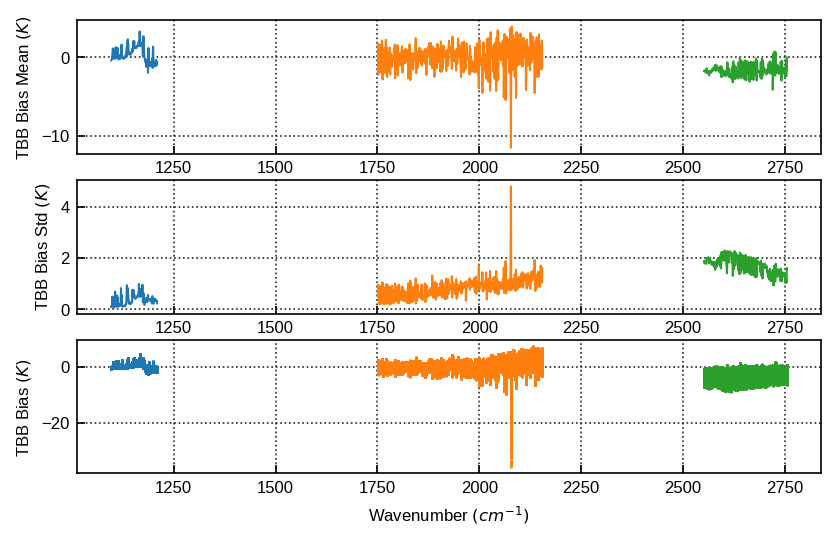

>>> Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/0000_650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_test_pca.png


In [173]:
out_filename_business = '0000_' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_{}.png'.format(model_name)
out_file_business = os.path.join(validate_dir, out_filename_business)
plot_model_validate(predict_Y_tbb_business, predict_Y_tbb_test, wavenumber_Y, index_Y, out_file_business)

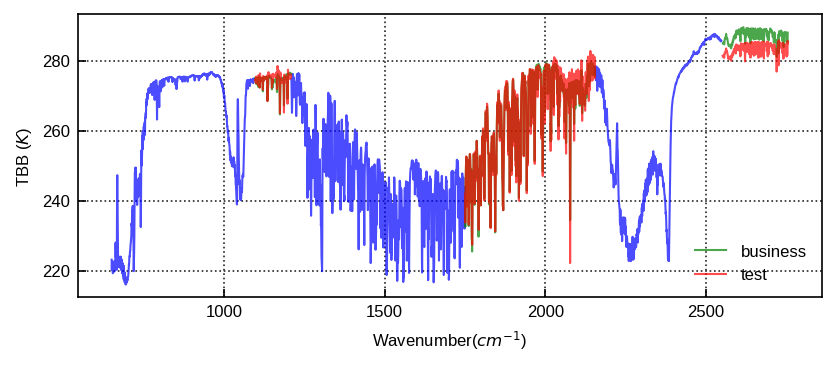

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_00_test_pca.png


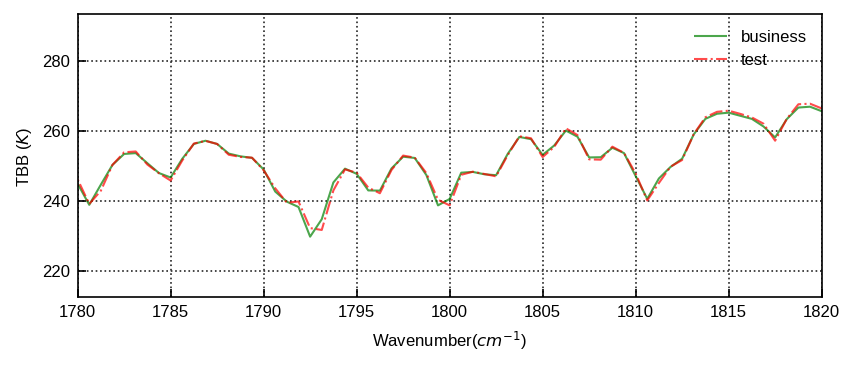

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_01_test_pca.png


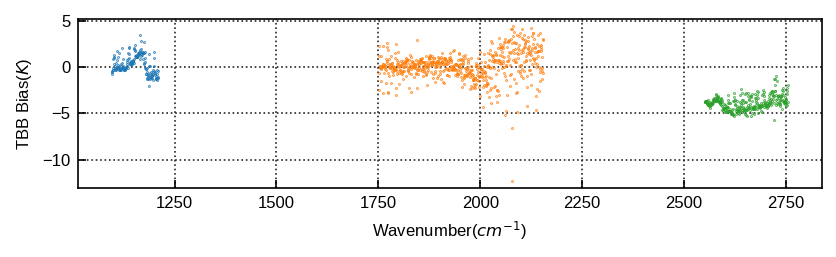

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_02_test_pca.png


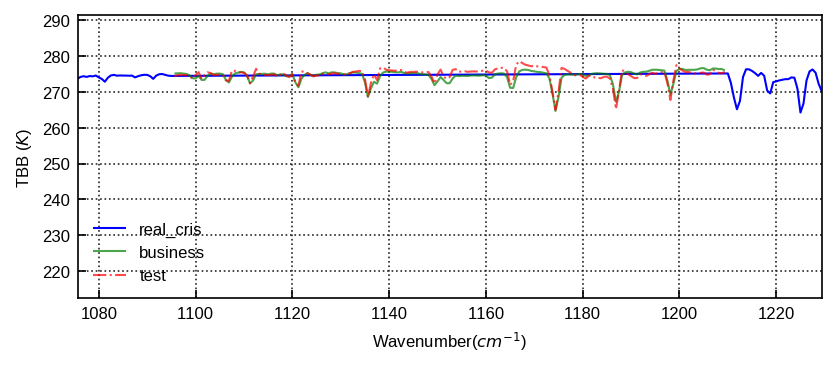

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_03_test_pca.png


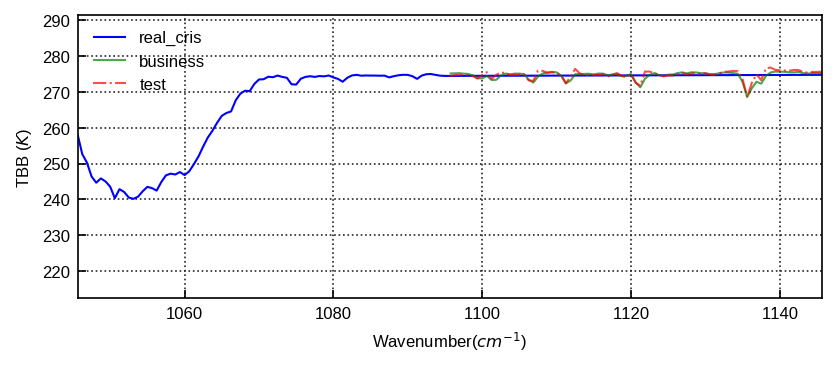

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_04_test_pca.png


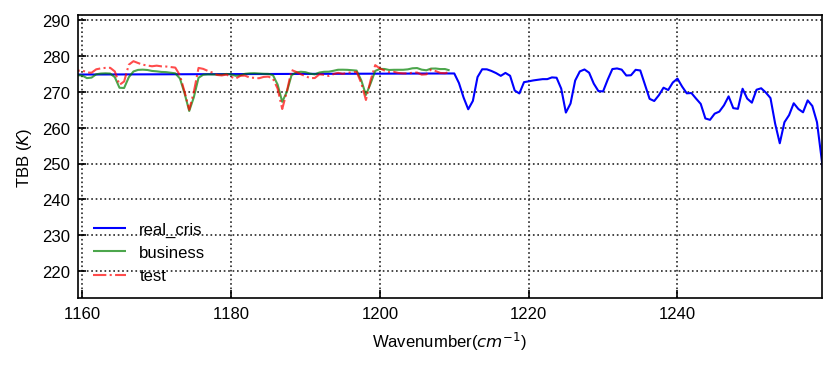

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_05_test_pca.png


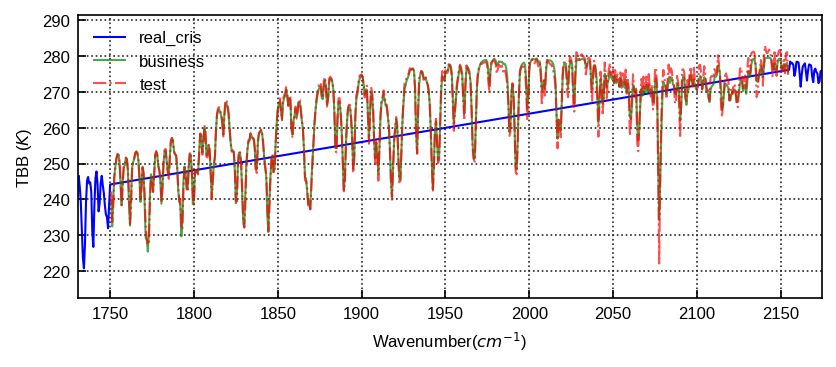

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_06_test_pca.png


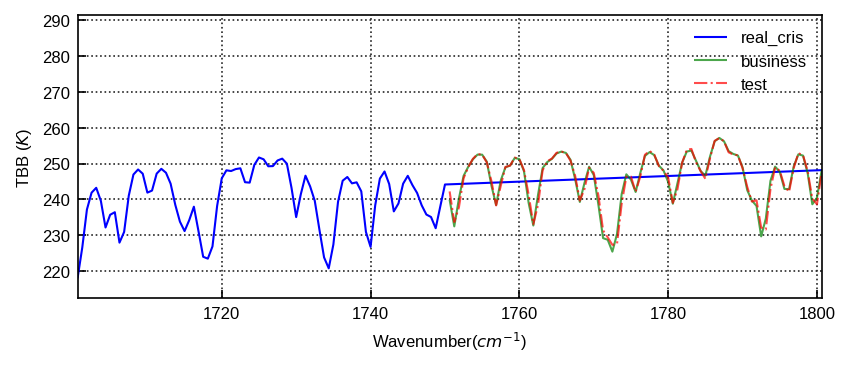

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_07_test_pca.png


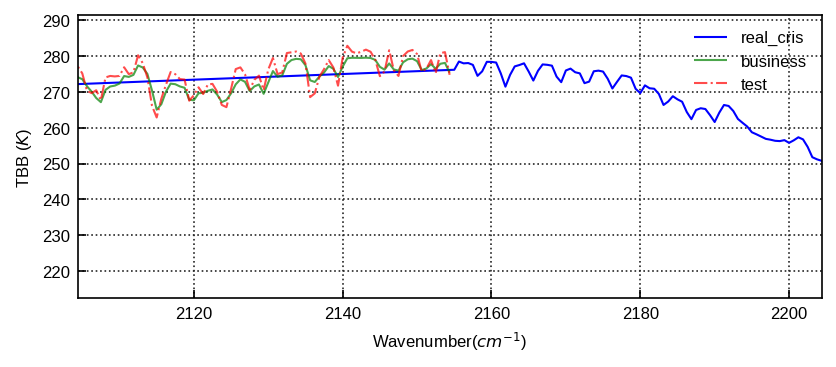

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_08_test_pca.png


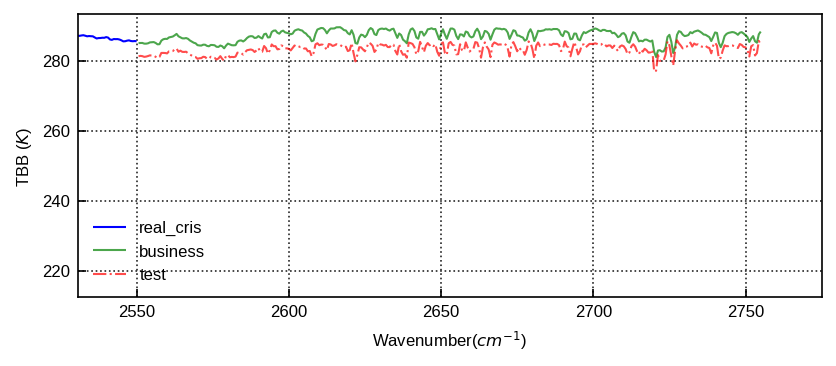

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_09_test_pca.png


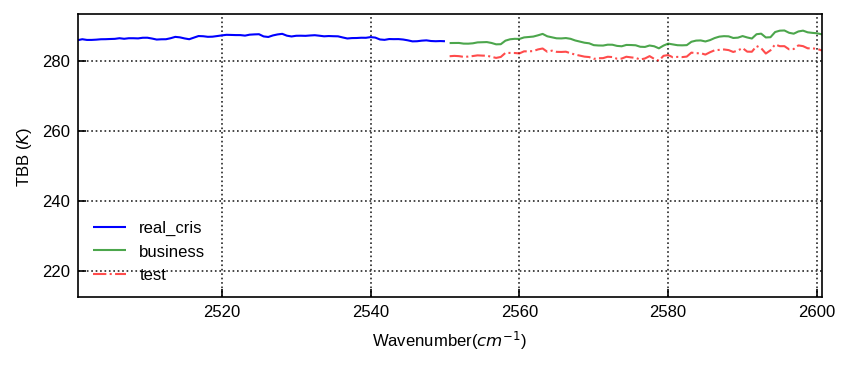

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_10_test_pca.png


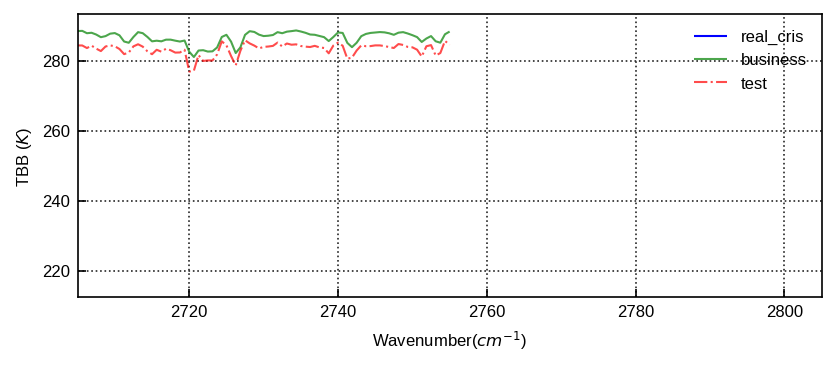

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0000_11_test_pca.png


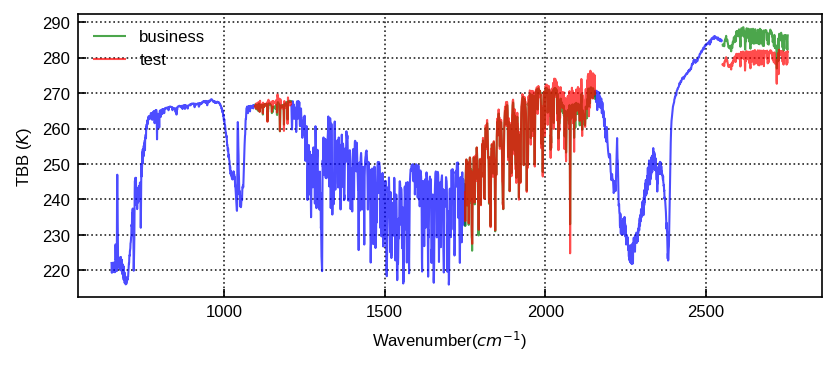

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_00_test_pca.png


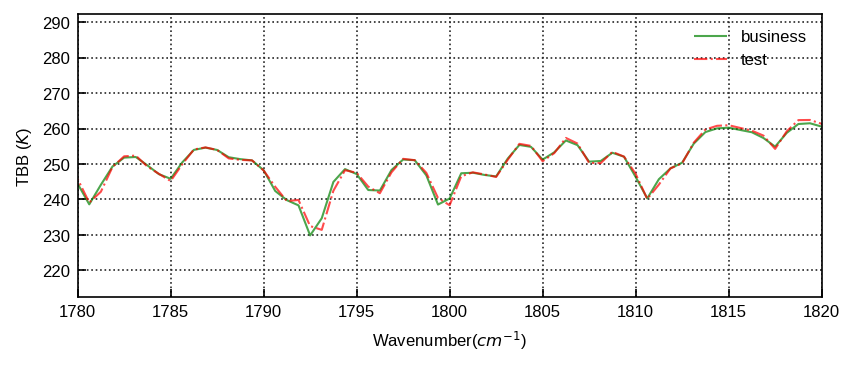

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_01_test_pca.png


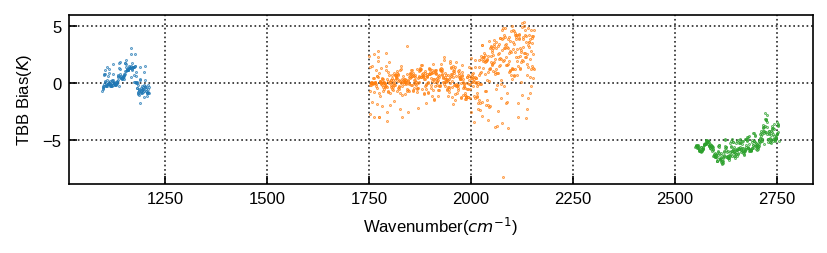

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_02_test_pca.png


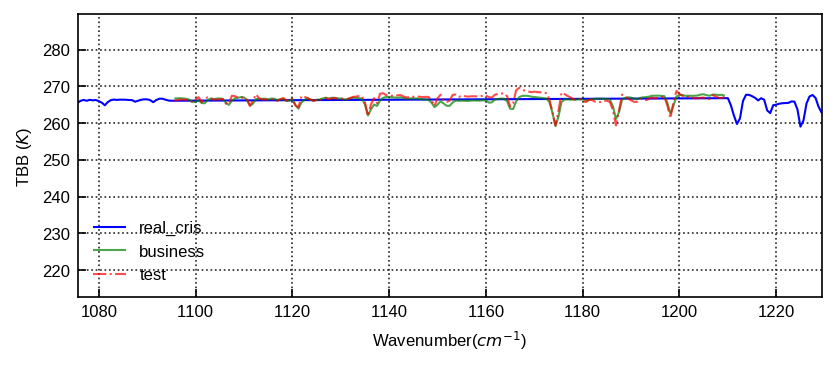

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_03_test_pca.png


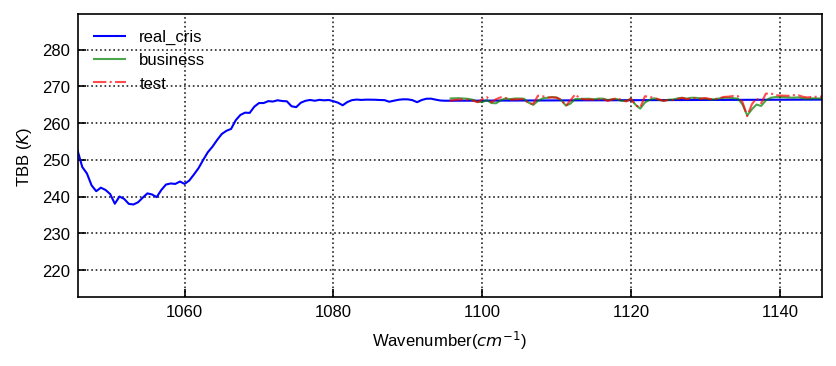

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_04_test_pca.png


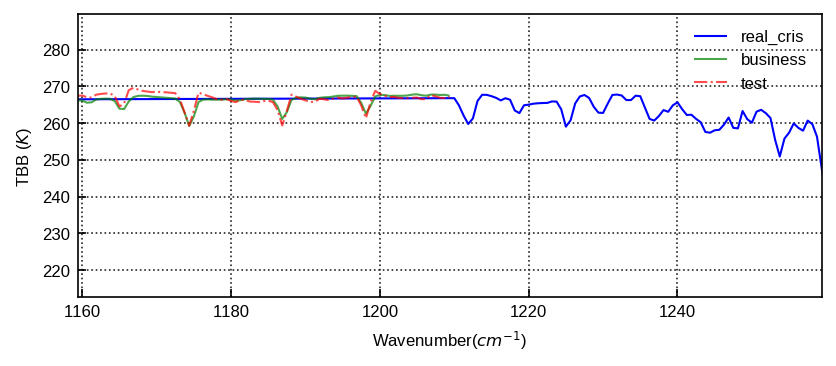

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_05_test_pca.png


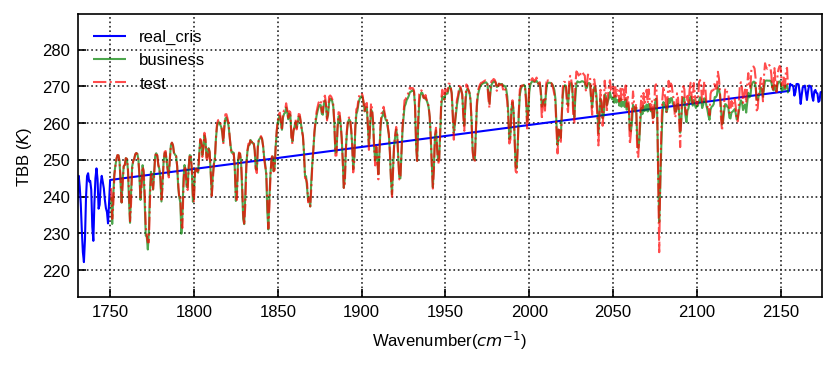

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_06_test_pca.png


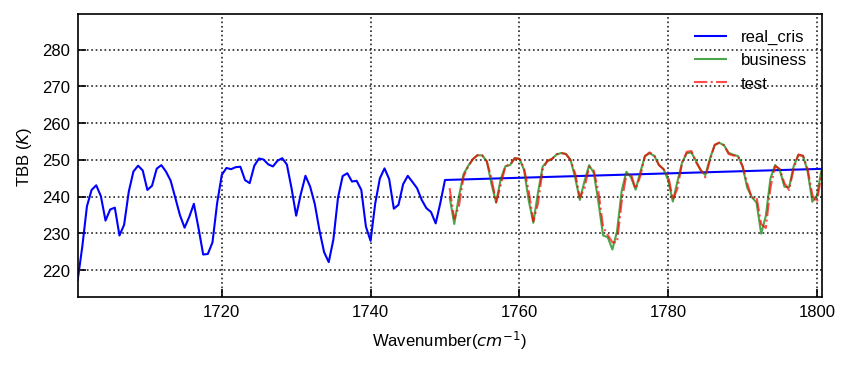

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_07_test_pca.png


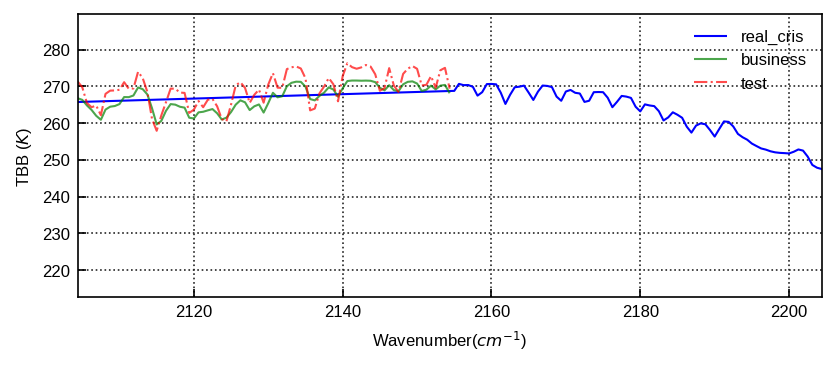

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_08_test_pca.png


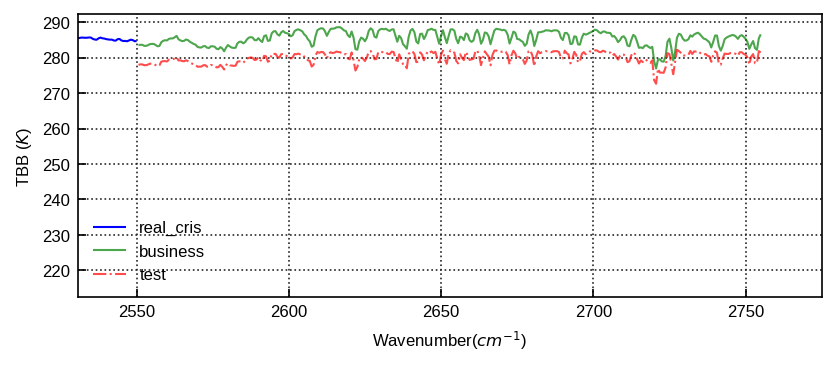

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_09_test_pca.png


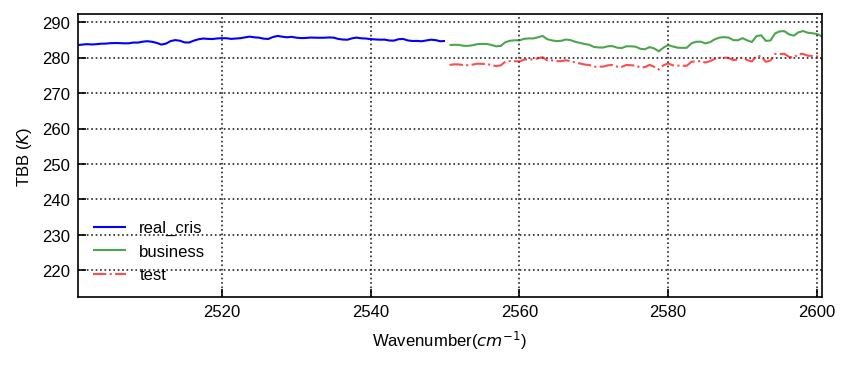

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_10_test_pca.png


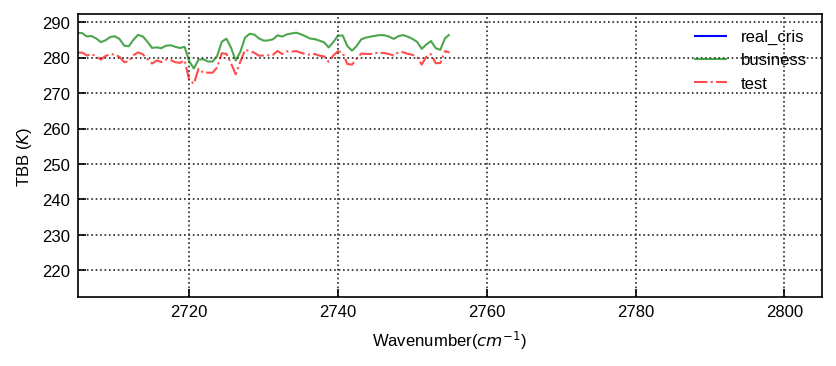

Result/650.0_1095.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1095.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_validate/s_0001_11_test_pca.png


In [174]:
number = 2
plot_validate_picture(test_X_tbb, predict_Y_tbb_business, predict_Y_tbb_test, model_name, number)